In [14]:
from __future__ import division
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import seaborn as sns
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from functools import reduce
from math import sqrt, exp
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [13]:
from finta import TA

from sklearn import svm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
def get_data_for_multiple_stocks(tickers, start_date, end_date):
    '''
    tickers: list of tickers to get data for
    start_date, end_date: dt.datetime objects
    method returns a dictionary b{ticker: pd.DataFrame}
    '''
    # start_date_str = start_date.strftime('%Y-%m-%d')
    # end_date_str = end_date.strftime('%Y-%m-%d')
    stocks = dict()
    # loop through all the tickers
    for i, ticker in enumerate(tickers):
        if i % 5 == 0:
            print(f'{i}/{len(tickers)}')

        try:
            # get the data for the specific ticker
            s = DataReader(ticker, 'yahoo', start_date, end_date)

            s.insert(0, "Ticker", ticker)

            s['Prev Close'] = s['Adj Close'].shift(1)
            s['daily_return'] = (s['Adj Close']/s['Prev Close']) - 1
            s['log_return'] = np.log(s['Adj Close']/s['Prev Close'])
            # s['perc_return'] = (s['Adj Close']/s['Prev Close'])
            # add it to the dictionary
            stocks[ticker] = s
        except:
            print(f'something went wrong with {ticker}')
            continue

    # return the dictionary
    return stocks

In [5]:
df = pd.read_csv('alphas_all.csv',parse_dates=['Date'])

In [6]:
df2 = df.drop('Date', axis=1)
tickers = list(df2.columns)

In [7]:
tickers

['NONOF',
 'NVO',
 'CMXHF',
 'CSLLY',
 'REGN',
 'VRTX',
 'WXIBF',
 'WXXWY',
 'SGEN',
 'MRNA',
 'BGNE',
 'ALXN',
 'RPRX',
 'GMAB',
 'GNMSF',
 'BNTX',
 'UCBJY',
 'SBHMY',
 'UCBJF',
 'SBMFF',
 'INCY',
 'ALNY',
 'BMRN',
 'MYOK',
 'ARGX',
 'SRPT',
 'TECH',
 'MRTX',
 'NBIX',
 'ASND',
 'CVAC',
 'JAZZ',
 'GLPG',
 'ACAD',
 'IONS',
 'EXEL',
 'ADPT',
 'XLRN',
 'CRSP',
 'ARWR',
 'UTHR',
 'RARE',
 'BPMC',
 'IOVA',
 'DNLI',
 'NVAX',
 'ARNA',
 'BBIO',
 'ABCM',
 'ALLO',
 'BHVN',
 'FOLD',
 'CBPO',
 'BLI',
 'ABCZF',
 'ABCZY',
 'IMVT',
 'ALLK',
 'HCM',
 'KOD',
 'TPTX',
 'VIR',
 'HALO',
 'RETA',
 'FATE',
 'IDRSF',
 'SAGE',
 'PTCT',
 'FGEN',
 'BLUE',
 'MOR',
 'LEGN',
 'MPSYF',
 'TGTX',
 'DCPH',
 'CCXI',
 'GBT',
 'RLAY',
 'INSM',
 'NKTR',
 'SWTX',
 'IMAB',
 'AGIO',
 'EIDX',
 'MCRB',
 'ALKS',
 'AXSM',
 'HRMY',
 'PHMMF',
 'APLS',
 'AVIR',
 'KRTX',
 'ADCT',
 'XNCR',
 'RVMD',
 'VCYT',
 'CORT',
 'MDGL',
 'AUPH',
 'EDIT',
 'REPL',
 'FMTX',
 'AMRN',
 'BEAM',
 'PCVX',
 'ITCI',
 'SRNE',
 'QURE',
 'VIE',
 'ZYME',
 'Y

In [7]:
# 28 stocks in portfolio
# ['EXAS','ARGX','SRPT','GLPG','NBIX','ASND','MRTX','MYOK','BPMC','BHVN','FOLD','GBT', 'GWPH','SAGE',
#                            'XNCR','AIMT','VCYT','QURE','MYOV','RCKT','ZGNX','COLL','CRNX', 'AVRO', 'XENE','MGTA','MNTA','RAFA']


In [9]:
stock_list =  get_data_for_multiple_stocks(tickers,start_date="2018-12-01", end_date = "2019-12-31")

0/845
5/845
10/845
something went wrong with RPRX
15/845
20/845
25/845
30/845
something went wrong with CVAC
35/845
40/845
45/845
something went wrong with ABCM
50/845
something went wrong with BLI
55/845
60/845
65/845
70/845
something went wrong with LEGN
75/845
something went wrong with RLAY
80/845
something went wrong with IMAB
85/845
something went wrong with HRMY
90/845
something went wrong with AVIR
something went wrong with ADCT
something went wrong with RVMD
95/845
100/845
something went wrong with FMTX
something went wrong with BEAM
something went wrong with PCVX
105/845
110/845
something went wrong with CSPHF
something went wrong with ALVR
115/845
something went wrong with RCPHF
something went wrong with KYMR
120/845
something went wrong with PMVP
something went wrong with ZNTL
125/845
something went wrong with PRLD
something went wrong with ALXO
something went wrong with KRON
130/845
135/845
140/845
145/845
something went wrong with PRAX
150/845
something went wrong with GBI

### Compute technical indicators

In [10]:
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [39]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['Open'])
    del (data['High'])
    del (data['Low'])
    del (data['Volume'])
    del (data['Adj Close'])
    
    return data


### Aggregate daily to monthly

In [ ]:
# find indicators for each stock & aggregate to monthly

for stock in stock_list.keys():
  data = _get_indicator_data(stock_list[stock])
  stock_list[stock] = data.resample('M').agg('last')

### Append monthly alpha values

In [16]:
train = pd.DataFrame()

for stock in stock_list.keys():
  stock_list[stock].reset_index(inplace=True)
  # append true alpha values
  df_stock = df[['Date', stock]]
  df_stock.rename(columns={ df_stock.columns[1]: "alpha" }, inplace = True)
  indicators_merge = stock_list[stock].merge(df_stock, on='Date', how='left')
  stock_list[stock] = indicators_merge
  # get labels
  stock_list[stock]['label'] = stock_list[stock]['alpha'].apply(lambda x: 1 if x>0 else 0)
  # lag
  cols = list(stock_list[stock].columns)
  del cols[0:2]
  del cols[-2:]
  for i in cols:
    stock_list[stock][i] = stock_list[stock][i].shift(1)
  # concatenate all stocks
  train = pd.concat([train,stock_list[stock]])

In [84]:
# number of stocks
len(list(stock_list))

758

In [17]:
train.head()

,Date,Ticker,Close,Prev Close,daily_return,log_return,14 period RSI,MACD,SIGNAL,14 period STOCH %K,...,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,alpha,label
0,2018-11-30,NONOF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2018-12-31,NONOF,46.490002,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,...,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0
2,2019-01-31,NONOF,45.290001,36.313129,0.005327,0.005313,49.181433,-0.208826,-0.191205,65.242223,...,-6.516372,0.730543,0.742291,1.001332,1.003218,1.004736,1.010488,0.034729,0.000576,1
3,2019-02-28,NONOF,46.889999,37.530285,0.007088,0.007063,52.331554,0.099910,0.218270,57.376988,...,-0.740993,1.092948,0.842949,1.011907,1.008380,1.006128,1.003483,2.329160,0.001840,1
4,2019-03-31,NONOF,48.430000,39.424534,-0.009814,-0.009862,50.868085,0.442578,0.548987,21.212181,...,22.963026,0.851711,1.036755,1.020255,1.009316,1.002663,0.991332,0.118928,0.007701,1


In [18]:
# drop rows with null values
train = train.dropna(axis=0)
# sort by date
train = train.sort_values(by=['Date'])

In [20]:
# reset index
train = train.reset_index().drop(['index'], axis=1)

In [44]:
# features not used for prediction
train.drop(['Prev Close', 'log_return'], axis=1, inplace=True)

In [45]:
train.head()

,Date,Ticker,Close,daily_return,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,...,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,alpha,label
0,2019-01-31,NONOF,45.290001,0.005327,49.181433,-0.208826,-0.191205,65.242223,-2.166930e+05,0.972857,...,-6.516372,0.730543,0.742291,1.001332,1.003218,1.004736,1.010488,0.034729,0.000576,1
1,2019-01-31,TTNP,1.320000,-0.043478,29.133351,-0.065842,-0.046424,20.000004,-4.438385e+06,0.141429,...,-0.010844,1.121212,0.878788,0.844644,0.857964,0.869113,0.918434,0.776699,-0.012116,0
2,2019-01-31,ALBO,24.530001,0.058240,52.536752,-0.352417,-0.461252,71.920541,4.505887e+05,1.892857,...,0.119650,1.061509,0.937358,1.025483,1.033877,1.040243,1.059498,0.513348,-0.004391,0
3,2019-01-31,VNDA,26.129999,0.018316,52.464992,-0.319860,-0.401472,60.408149,1.870759e+07,1.534286,...,-0.252777,1.063315,0.887337,0.994504,1.001167,1.006205,1.021541,0.937148,-0.006013,0
4,2019-01-31,CARA,13.000000,0.023622,24.809143,-0.568148,-0.532689,19.285725,-5.567916e+06,0.859571,...,-0.288190,1.288350,0.768157,0.896598,0.912994,0.926012,0.974588,0.753728,0.000565,1


<AxesSubplot:title={'center':'Class Distribution'}>

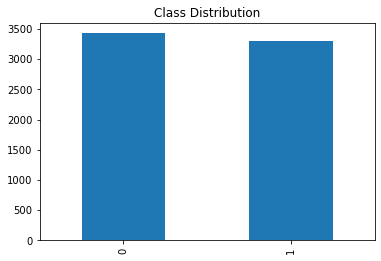

In [46]:
# class distribution
train['label'].value_counts().plot.bar(title="Class Distribution")

### Retrieve test data 

In [60]:
stock_list_test =  get_data_for_multiple_stocks(tickers,start_date="2019-12-01", end_date = "2020-10-31")

0/845
5/845
10/845
15/845
20/845
25/845
30/845
35/845
40/845
45/845
50/845
55/845
60/845
65/845
70/845
75/845
80/845
85/845
90/845
95/845
100/845
105/845
110/845
115/845
120/845
125/845
130/845
135/845
140/845
145/845
150/845
155/845
160/845
165/845
170/845
175/845
180/845
185/845
190/845
195/845
200/845
205/845
210/845
215/845
220/845
225/845
230/845
235/845
240/845
245/845
250/845
255/845
260/845
265/845
270/845
275/845
280/845
285/845
290/845
295/845
300/845
305/845
310/845
315/845
320/845
325/845
330/845
335/845
340/845
345/845
350/845
355/845
360/845
365/845
370/845
375/845
380/845
385/845
390/845
395/845
400/845
405/845
410/845
415/845
420/845
425/845
430/845
435/845
440/845
445/845
450/845
455/845
460/845
465/845
470/845
475/845
480/845
485/845
490/845
495/845
500/845
505/845
510/845
515/845
520/845
525/845
530/845
535/845
540/845
545/845
550/845
555/845
560/845
565/845
570/845
575/845
580/845
585/845
590/845
595/845
600/845
605/845
610/845
615/845
620/845
625/845
630/845
635/84

In [61]:
# find indicators for each stock & aggregate to monthly

for stock in stock_list_test.keys():
  data = _get_indicator_data(stock_list_test[stock])
  stock_list_test[stock] = data.resample('M').agg('last')

In [62]:
test = pd.DataFrame()

for stock in stock_list_test.keys():
  stock_list_test[stock].reset_index(inplace=True)
  # append true alpha values
  df_stock = df[['Date', stock]]
  df_stock.rename(columns={ df_stock.columns[1]: "alpha" }, inplace = True)
  indicators_merge = stock_list_test[stock].merge(df_stock, on='Date', how='left')
  stock_list_test[stock] = indicators_merge
  # get labels
  stock_list_test[stock]['label'] = stock_list_test[stock]['alpha'].apply(lambda x: 1 if x>0 else 0)
  # print(stock_list[stock])
  # lag
  cols = list(stock_list_test[stock].columns)
  del cols[0:2]
  del cols[-2:]
  for i in cols:
    stock_list_test[stock][i] = stock_list_test[stock][i].shift(1)
  # print(stock_list[stock])
  # concatenate all stocks
  test = pd.concat([test,stock_list_test[stock]])

In [63]:
test.head()

,Date,Ticker,Close,Prev Close,daily_return,log_return,14 period RSI,MACD,SIGNAL,14 period STOCH %K,...,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,alpha,label
0,2019-12-31,NONOF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000976,1
1,2020-01-31,NONOF,57.849998,55.455078,-0.008229,-0.008263,57.563314,0.245262,0.189146,74.796666,...,-153.553742,0.919110,0.700708,1.011399,1.009679,1.008309,1.003009,0.072372,0.002741,1
2,2020-02-29,NONOF,60.799999,57.299461,0.008794,0.008755,56.766071,0.740648,0.792921,54.975095,...,211.809761,0.833642,0.824399,1.034557,1.025864,1.019636,1.004326,0.123692,-0.002792,0
3,2020-03-31,NONOF,57.709999,56.919174,-0.036078,-0.036745,35.225666,-0.178576,0.472981,0.000000,...,-540.451165,0.987170,0.768302,0.957129,0.946296,0.941468,0.944660,0.083497,0.001860,1
4,2020-04-30,NONOF,58.349998,55.474091,0.000000,0.000000,55.185872,-1.235405,-2.009535,86.359688,...,1749.501425,0.851011,0.863792,1.001354,1.019024,1.034503,1.062849,3.348938,0.005182,1


In [64]:
# drop rows with null values
test = test.dropna(axis=0)
# sort by date
test = test.sort_values(by=['Date'])

In [65]:
test.head()

,Date,Ticker,Close,Prev Close,daily_return,log_return,14 period RSI,MACD,SIGNAL,14 period STOCH %K,...,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,alpha,label
1,2020-01-31,NONOF,57.849998,55.455078,-0.008229,-0.008263,57.563314,0.245262,0.189146,74.796666,...,-1.535537e+02,0.919110,0.700708,1.011399,1.009679,1.008309,1.003009,0.072372,0.002741,1
1,2020-01-31,CMRX,2.030000,2.030000,0.000000,0.000000,42.082752,-0.028299,-0.035146,55.102036,...,-4.290762e-03,1.269035,1.121827,0.953747,0.962352,0.968431,0.984763,0.741564,-0.007942,0
1,2020-01-31,IMNPQ,0.003200,0.003850,-0.168831,-0.184922,51.087204,0.000170,0.000132,43.636361,...,1.660962e-07,0.875204,1.051387,1.052746,1.032014,1.015295,0.952038,0.533879,0.011501,1
1,2020-01-31,AUPH,20.260000,20.240000,0.000988,0.000988,79.074976,1.008782,1.004906,66.666667,...,6.622163e-02,0.836470,1.200519,1.142908,1.110897,1.088133,1.020115,0.678846,-0.003592,0
1,2020-01-31,ATOS,1.570000,1.600000,-0.018750,-0.018928,55.452575,0.035176,0.029216,44.000006,...,-1.378781e-02,0.945455,1.072727,1.039356,1.030071,1.022619,0.994558,0.714054,-0.003261,0


In [66]:
test = test.reset_index().drop(['index'], axis=1)

In [67]:
test.drop(['Prev Close', 'log_return'], axis=1, inplace=True)

In [73]:
test.head()

,Date,Ticker,Close,daily_return,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,...,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,alpha,label
0,2020-01-31,NONOF,57.849998,-0.008229,57.563314,0.245262,0.189146,74.796666,-1.559083e+05,0.706429,...,-1.535537e+02,0.919110,0.700708,1.011399,1.009679,1.008309,1.003009,0.072372,0.002741,1
1,2020-01-31,CMRX,2.030000,0.000000,42.082752,-0.028299,-0.035146,55.102036,-4.540899e+06,0.140714,...,-4.290762e-03,1.269035,1.121827,0.953747,0.962352,0.968431,0.984763,0.741564,-0.007942,0
2,2020-01-31,IMNPQ,0.003200,-0.168831,51.087204,0.000170,0.000132,43.636361,-9.965421e+06,0.000876,...,1.660962e-07,0.875204,1.051387,1.052746,1.032014,1.015295,0.952038,0.533879,0.011501,1
3,2020-01-31,AUPH,20.260000,0.000988,79.074976,1.008782,1.004906,66.666667,4.268629e+07,1.100714,...,6.622163e-02,0.836470,1.200519,1.142908,1.110897,1.088133,1.020115,0.678846,-0.003592,0
4,2020-01-31,ATOS,1.570000,-0.018750,55.452575,0.035176,0.029216,44.000006,-1.031720e+06,0.117857,...,-1.378781e-02,0.945455,1.072727,1.039356,1.030071,1.022619,0.994558,0.714054,-0.003261,0


### Merge train and test data 

In [75]:
final_df = pd.concat([train, test])

In [76]:
print(final_df)

           Date Ticker      Close  daily_return  14 period RSI      MACD  \
0    2019-01-31  NONOF  45.290001      0.005327      49.181433 -0.208826   
1    2019-01-31   TTNP   1.320000     -0.043478      29.133351 -0.065842   
2    2019-01-31   ALBO  24.530001      0.058240      52.536752 -0.352417   
3    2019-01-31   VNDA  26.129999      0.018316      52.464992 -0.319860   
4    2019-01-31   CARA  13.000000      0.023622      24.809143 -0.568148   
...         ...    ...        ...           ...            ...       ...   
6275 2020-10-31   CBAY   7.240000      0.022599      64.799084  0.275986   
6276 2020-10-31   ABVC   4.000000      0.000000      53.535585  0.032774   
6277 2020-10-31    SYN   0.470000     -0.020833      42.658162 -0.019826   
6278 2020-10-31   INZY  26.290001      0.099540      56.735213 -0.673315   
6279 2020-10-31  RVXCF   0.970000     -0.020202      68.460861  0.102167   

        SIGNAL  14 period STOCH %K           MFV  14 period ATR  ...  \
0    -0.191205 

In [77]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13011 entries, 0 to 6279
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                13011 non-null  datetime64[ns]
 1   Ticker              13011 non-null  object        
 2   Close               13011 non-null  float64       
 3   daily_return        13011 non-null  float64       
 4   14 period RSI       13011 non-null  float64       
 5   MACD                13011 non-null  float64       
 6   SIGNAL              13011 non-null  float64       
 7   14 period STOCH %K  13011 non-null  float64       
 8   MFV                 13011 non-null  float64       
 9   14 period ATR       13011 non-null  float64       
 10  MOM                 13011 non-null  float64       
 11  14 period MFI       13011 non-null  float64       
 12  ROC                 13011 non-null  float64       
 13  OBV                 13011 non-null  float64    

In [79]:
# create month numbering column to loop for model training
days = list(set(final_df['Date']))
days.sort()
day_no = list()
for index,day in enumerate(days):
    counter=1
    for dfday in final_df['Date']:
        if dfday == day:
            day_no.append(index+1)
            counter+=1

final_df['month'] = pd.Series(day_no).values 

In [85]:
final_df.tail()

,Date,Ticker,Close,daily_return,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,...,VIm,VIp,ema50,ema21,ema15,ema5,normVol,alpha,label,month
6275,2020-10-31,CBAY,7.240000,0.022599,64.799084,0.275986,0.241154,92.265174,-1.728539e+08,0.577857,...,0.850309,1.090111,1.462931,1.209299,1.150769,1.088248,1.878242,0.008877,1,22
6276,2020-10-31,ABVC,4.000000,0.000000,53.535585,0.032774,0.031901,72.727265,-2.241720e+04,0.182143,...,0.745098,0.686274,1.108046,1.037928,1.020020,1.008144,1.823359,-0.001554,0,22
6277,2020-10-31,SYN,0.470000,-0.020833,42.658162,-0.019826,-0.018134,54.545464,-4.531088e+07,0.033571,...,0.957447,0.893617,0.947414,0.917677,0.927842,0.974319,0.459715,-0.012364,0,22
6278,2020-10-31,INZY,26.290001,0.099540,56.735213,-0.673315,-0.839189,98.132450,5.892272e+06,2.476286,...,1.006634,0.977068,1.052968,1.056431,1.065094,1.100682,0.706485,-0.003772,0,22
6279,2020-10-31,RVXCF,0.970000,-0.020202,68.460861,0.102167,0.068127,71.698119,-3.847195e+06,0.077143,...,0.611111,1.175926,1.474838,1.378243,1.299966,1.111030,0.457019,-0.011363,0,22


In [90]:
# reset index
final_df = final_df.reset_index().drop(['index'], axis=1)

In [91]:
final_df.tail()

,Date,Ticker,Close,daily_return,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,...,VIm,VIp,ema50,ema21,ema15,ema5,normVol,alpha,label,month
13006,2020-10-31,CBAY,7.240000,0.022599,64.799084,0.275986,0.241154,92.265174,-1.728539e+08,0.577857,...,0.850309,1.090111,1.462931,1.209299,1.150769,1.088248,1.878242,0.008877,1,22
13007,2020-10-31,ABVC,4.000000,0.000000,53.535585,0.032774,0.031901,72.727265,-2.241720e+04,0.182143,...,0.745098,0.686274,1.108046,1.037928,1.020020,1.008144,1.823359,-0.001554,0,22
13008,2020-10-31,SYN,0.470000,-0.020833,42.658162,-0.019826,-0.018134,54.545464,-4.531088e+07,0.033571,...,0.957447,0.893617,0.947414,0.917677,0.927842,0.974319,0.459715,-0.012364,0,22
13009,2020-10-31,INZY,26.290001,0.099540,56.735213,-0.673315,-0.839189,98.132450,5.892272e+06,2.476286,...,1.006634,0.977068,1.052968,1.056431,1.065094,1.100682,0.706485,-0.003772,0,22
13010,2020-10-31,RVXCF,0.970000,-0.020202,68.460861,0.102167,0.068127,71.698119,-3.847195e+06,0.077143,...,0.611111,1.175926,1.474838,1.378243,1.299966,1.111030,0.457019,-0.011363,0,22


In [110]:
final_df["Val_Class"] = np.nan # classification prediction for validation set
final_df["Test_Class"] = np.nan # classification prediction for test set
final_df["Val_Reg"] = np.nan # regression prediction for validation set
final_df["Test_Reg"] = np.nan # regression prediction for test set

In [111]:
final_df.head()

,Date,Ticker,Close,daily_return,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,...,ema15,ema5,normVol,alpha,label,month,Val_Class,Test_Class,Val_Reg,Test_Reg
0,2019-01-31,NONOF,45.290001,0.005327,49.181433,-0.208826,-0.191205,65.242223,-2.166930e+05,0.972857,...,1.004736,1.010488,0.034729,0.000576,1,1,NaN,NaN,NaN,NaN
1,2019-01-31,TTNP,1.320000,-0.043478,29.133351,-0.065842,-0.046424,20.000004,-4.438385e+06,0.141429,...,0.869113,0.918434,0.776699,-0.012116,0,1,NaN,NaN,NaN,NaN
2,2019-01-31,ALBO,24.530001,0.058240,52.536752,-0.352417,-0.461252,71.920541,4.505887e+05,1.892857,...,1.040243,1.059498,0.513348,-0.004391,0,1,NaN,NaN,NaN,NaN
3,2019-01-31,VNDA,26.129999,0.018316,52.464992,-0.319860,-0.401472,60.408149,1.870759e+07,1.534286,...,1.006205,1.021541,0.937148,-0.006013,0,1,NaN,NaN,NaN,NaN
4,2019-01-31,CARA,13.000000,0.023622,24.809143,-0.568148,-0.532689,19.285725,-5.567916e+06,0.859571,...,0.926012,0.974588,0.753728,0.000565,1,1,NaN,NaN,NaN,NaN


In [112]:
# use Jan-Nov as training / Dec as validation, Jan 2020 as test
# repeat for subsequent months till Oct 2020 as test

for i in range (1, 11):
    print("Predicting Month "+str(i+12))
    start_index_train = final_df.loc[final_df['month'] >= i].index[0]
    end_index_train = final_df.loc[final_df['month'] >= (i+11)].index[0]
    end_index_val = final_df.loc[final_df['month'] >= (i+12)].index[0]
    training = final_df[start_index_train:end_index_train]
    validation = final_df[end_index_train:end_index_val]
    if i==10:
        test = final_df[end_index_val:]
    else:
        end_index_test = final_df.loc[final_df['month'] >= (i+13)].index[0]
        test = final_df[end_index_val:end_index_test]
    
    y_train = training['label']
    x_train = training.drop(['Date', 'Ticker', 'alpha','label', 'month'], axis=1)
    y_val = validation['label']
    x_val = validation.drop(['Date', 'Ticker', 'alpha','label', 'month'], axis=1)
    y_test = test['label']
    x_test = test.drop(['Date', 'Ticker', 'alpha','label', 'month'], axis=1)
    
    XG = XGBClassifier(random_state = 4016)
    XG.fit(x_train, y_train)
    
    y_pred = XG.predict(x_val)
    
    final_df.loc[final_df['month'] == (i+11), "Val_Class"] = y_pred

    # Create confusion matrix of validation data
    cm = confusion_matrix(y_val, y_pred)
    TN, FP, FN, TP = cm.ravel()
    print("Validation Confusion Matrix: \n", cm)
    print("True negative: %s, False positive: %s, False negative: %s, True positive: %s" %(TN, FP, FN, TP))

    # Performance of decision tree model on validation data
    print("Accuracy: ", accuracy_score(y_val, y_pred))
    print("Recall: ", recall_score(y_val, y_pred))
    print("Precision: ", precision_score(y_val, y_pred))
    print("MCC: ", matthews_corrcoef(y_val, y_pred))
    print("F1: ", f1_score(y_val, y_pred))

    y_pred_test = XG.predict(x_test)
    
    final_df.loc[final_df['month'] == (i+12), "Test_Class"] = y_pred_test

    # Create confusion matrix of validation data
    cm = confusion_matrix(y_test, y_pred_test)
    TN, FP, FN, TP = cm.ravel()
    print("Test Confusion Matrix: \n", cm)
    print("True negative: %s, False positive: %s, False negative: %s, True positive: %s" %(TN, FP, FN, TP))

    # Performance of decision tree model on validation data
    print("Accuracy: ", accuracy_score(y_test, y_pred_test))
    print("Recall: ", recall_score(y_test, y_pred_test))
    print("Precision: ", precision_score(y_test, y_pred_test))
    print("MCC: ", matthews_corrcoef(y_test, y_pred_test))
    print("F1: ", f1_score(y_test, y_pred_test))
    
    y_train_reg = training['alpha']
    y_val_reg = validation['alpha']
    y_test_reg = test['alpha']
    
    xg_reg = XGBRegressor(objective='reg:squarederror', random_state=4016)
    xg_reg.fit(x_train, y_train_reg)
    y_pred_reg = xg_reg.predict(x_val)
    
    final_df.loc[final_df['month'] == (i+11), "Val_Reg"] = y_pred_reg
    
    mse = mean_squared_error(y_val_reg, y_pred_reg)
    print("Validation MSE: ", mse)

    y_pred_reg_test = xg_reg.predict(x_test)
    
    final_df.loc[final_df['month'] == (i+12), "Test_Reg"] = y_pred_reg_test
    
    mse = mean_squared_error(y_test_reg, y_pred_reg_test)
    print("Test MSE: ", mse)

Predicting Month13
Validation Confusion Matrix: 
 [[125  90]
 [236 146]]
True negative: 125, False positive: 90, False negative: 236, True positive: 146
Accuracy:  0.4539363484087102
Recall:  0.38219895287958117
Precision:  0.6186440677966102
MCC:  -0.03574461917843351
F1:  0.47249190938511326
Test Confusion Matrix: 
 [[133  98]
 [195 159]]
True negative: 133, False positive: 98, False negative: 195, True positive: 159
Accuracy:  0.49914529914529915
Recall:  0.4491525423728814
Precision:  0.6186770428015564
MCC:  0.02453465325419269
F1:  0.5204582651391162
Validation MSE:  0.00034959416664065516
Test MSE:  0.0006062117440236274
Predicting Month14
Validation Confusion Matrix: 
 [[131 100]
 [202 152]]
True negative: 131, False positive: 100, False negative: 202, True positive: 152
Accuracy:  0.48376068376068376
Recall:  0.4293785310734463
Precision:  0.6031746031746031
MCC:  -0.0034766620712109878
F1:  0.5016501650165016
Test Confusion Matrix: 
 [[277 106]
 [167  55]]
True negative: 277,

In [115]:
# 28 stocks
fund_tickers = ['EXAS','ARGX','SRPT','GLPG','NBIX','ASND','MRTX','MYOK','BPMC','BHVN','FOLD','GBT', 'GWPH','SAGE', 'XNCR','AIMT','VCYT','QURE','MYOV','RCKT','ZGNX','COLL','CRNX', 'AVRO', 'XENE','MGTA','MNTA','RAFA']

In [116]:
output = final_df[final_df['Ticker'].isin(fund_tickers)]

In [117]:
output.to_csv("output_predictions.csv")